**You need to submit 2 things:**
- On **Crowdmark**, answers to each question:
 - for questions without code, as usual (you can take a screenshot of your answer in the colab cell or write it down on a separate medium)
 - for questions with code, take a screenshot of the code and upload it to Crowdmark
- On **Quercus**, submit a ipynb file with your entire code

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation.

In [ ]:
import csv
from typing import Callable, Tuple

import jax
import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip install --upgrade objax
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

In [ ]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 134MB/s]


In [ ]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:

apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$

We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.




When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:

1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)

3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.


The following function performs the above-mentioned steps for our IMDB dataset.



In [ ]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len:
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

The fit_on_texts function processes all the provided texts, counts the occurences of each word, assigns a unique index to each word, and arranges them based on the index. More frequent words receive lower indices.

**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

The texts_to_sequences function converts input texts into sequences of integers, utilizing the index established earlier in fit_on_texts. The output is a list of sequences, where each sequence corresponds to a text input, and each word in the text is represented by its integer index.

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

The pad_sequences function ensure that all sequences in a list have the same length. The process combines input sequences into a NumPy array, ensuring uniform length for all sequences by padding them according to the specified max_len parameter.







In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [ ]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [ ]:
print(messages_train[0])

[ 634   12  239  110  846   36  172   30  224  196    1  434  365   55
    3  279    7    7  157 1726  190    6    1  738 1993    1 1180    4
 1882    2  146  145    3  226    4    3  207  326    2  145 1077   16
   88    4  132   18   10  154   99    4    1  300   11   17  989   36
    1  495  492  250   73   76  106  106  696   60   85 1057 1343    5
  229  132   23   31  138  212 1133   14   31    3    2    8   11    6
    3  448   14  619    4    1  719    1 1245    2   73    1  164 1514
    1 1239    5 1674    1  888 1261    5    1  309  140    2  410  624
    7    7    1  272    6 1010    5   26   39   14 1378  217   65    2
   46    6   30  224   27  191 1473    8 1088   18   10   84    1  227
   66  358   68   54   27    5   15   44   21  193    5    3  879 1773
   22   25    5  160  197  176    3  111   12 1569  472   75  221    5
  327    2   35   23   51   71 1890   14    9 1388   11   19    6    3
   16   61    1  469  533    2    3  171 1776    5  586    9   36    1
  454 

Observing a sequence of integers, it's apparent that lower numbers appear more frequently, aligning with the intended outcome.







# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this mapping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry.

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows.

In [ ]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence? \\

`__init__` creates a training variable self.w, which is a matrix of dimensions (size: size of the input vocabulary, latent: size of the embedding vector). Each row of this matrix is the embedding vector for a corresponding word in the vocabulary. \\

`__call__` executes the embedding transformation on input sentences. It utilizes the indices in the integer array x, where each integer represents a specific word in the sentence, to select relevant rows from the self.w.value embedding matrix. Consequently, the function produces an output array in which every word from the input sentence x is replaced with its associated embedding vector from self.w.value.


# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

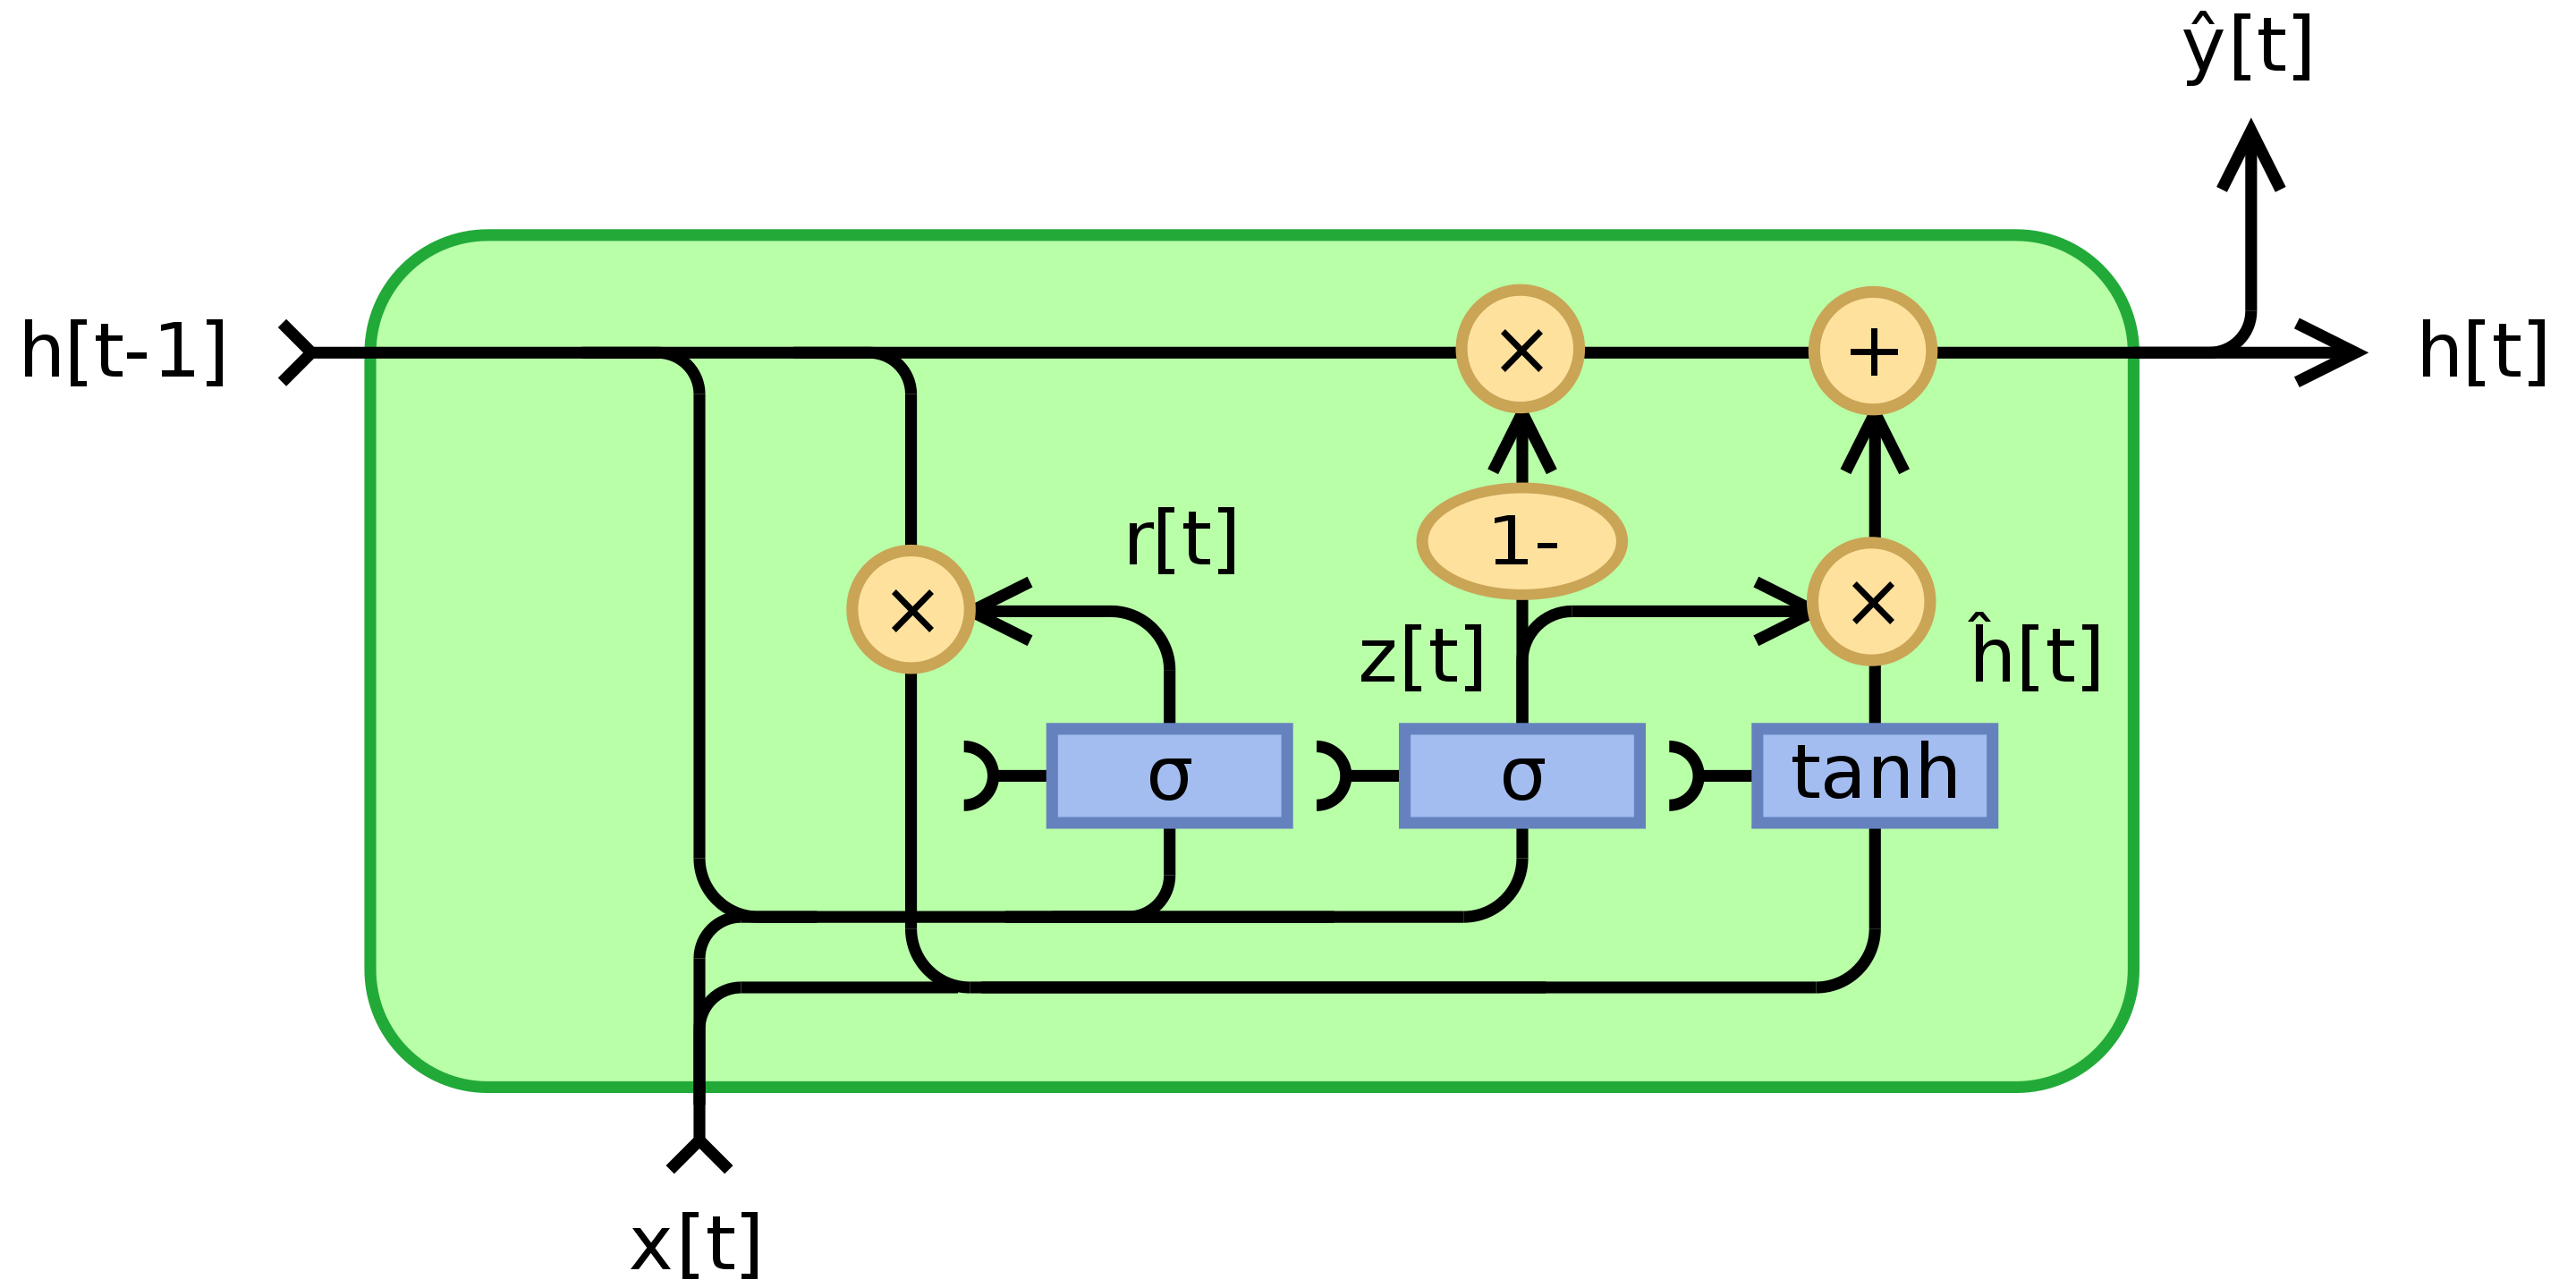

To learn more about GRU, please watch these short videos:

https://www.youtube.com/watch?v=8HyCNIVRbSU

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function.

In [ ]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = jax.nn.sigmoid(x @ self.update_w + state @ self.update_u + self.update_b)

            # fill this in
            reset_gate = jax.nn.sigmoid(x @ self.reset_w + state @ self.reset_u + self.reset_b)

            # fill this in
            output_gate = jn.tanh(x @ self.output_w + (reset_gate * state) @ self.output_u + self.output_b)

            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

In [ ]:
def cummulative(carry, x):
    carry += x
    return carry, carry

# Initial value (starting sum) and the input array
carry_init = 0
arr = np.array([1, 2, 3, 4])

# Performing the scan
sum, sums = lax.scan(cummulative, carry_init, arr)

print(sum, sums)

10 [ 1  3  6 10]


lax.scan is a special kind of loop. For each item in the array, lax.scan applies a function that was defined earlier and this function does some calculation with the current array item and a "carry" value. The "carry" value is updated each time the function is applied and is passed on to the next item in the array. This way, each step of the calculation can build on the results of the previous steps.

lax.scan is useful in processing through the Gated Recurrent Units as it enables the preservation and passing of the state from the previous time step, h[t−1], improving efficiency.

# The classifier

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [ ]:
# fill this in:
gru_rnn = objax.nn.Sequential([ Embed(size = max_len, latent = embedding_size),
                                GRU(nin = embedding_size, nout = num_hidden_units_GRU),
                                objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
                                objax.functional.relu,
                                objax.nn.Linear(num_hidden_units, 2)
])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [ ]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w          6000 (200, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       13472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU.

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [ ]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [ ]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [ ]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
def train(learning_rate, num_epochs, batch_size, training_data, validation_data, test_data):

  X_train, Y_train = training_data
  X_valid, Y_valid = validation_data
  X_test, Y_test = test_data

  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(num_epochs):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], batch_size):
          batch = train_indices[it:it + batch_size]  # MY CODE
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], learning_rate)[0]) * len(batch)
          train_prediction = eval_op(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], batch_size):
          batch = val_indices[it:it + batch_size]  # MY CODE
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = eval_op(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

  print("Test Accuracy is ", accuracy((X_test, Y_test)))

Epoch 0001  Training Loss 173.07 Validation Loss 172.53 Training Accuracy 52.59 Validation Accuracy 54.18
Epoch 0002  Training Loss 172.46 Validation Loss 171.68 Training Accuracy 54.76 Validation Accuracy 55.32
Epoch 0003  Training Loss 171.27 Validation Loss 169.61 Training Accuracy 56.64 Validation Accuracy 57.42
Epoch 0004  Training Loss 169.28 Validation Loss 191.83 Training Accuracy 58.42 Validation Accuracy 49.52
Epoch 0005  Training Loss 167.12 Validation Loss 162.31 Training Accuracy 60.03 Validation Accuracy 62.14
Epoch 0006  Training Loss 164.66 Validation Loss 156.91 Training Accuracy 61.97 Validation Accuracy 65.62
Epoch 0007  Training Loss 162.04 Validation Loss 161.66 Training Accuracy 63.27 Validation Accuracy 62.56
Epoch 0008  Training Loss 160.55 Validation Loss 157.39 Training Accuracy 64.70 Validation Accuracy 65.64
Epoch 0009  Training Loss 159.62 Validation Loss 149.91 Training Accuracy 65.13 Validation Accuracy 68.68
Epoch 0010  Training Loss 156.80 Validation Lo

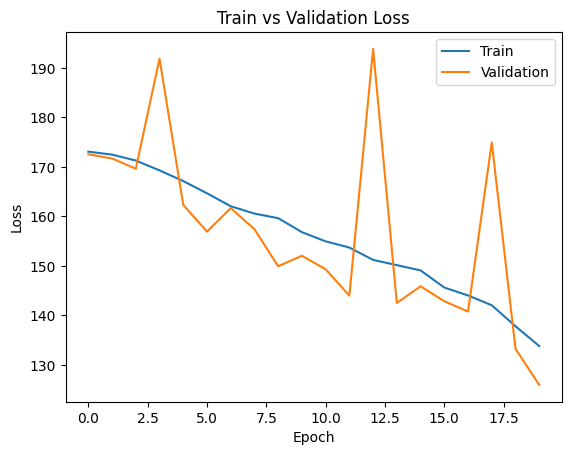

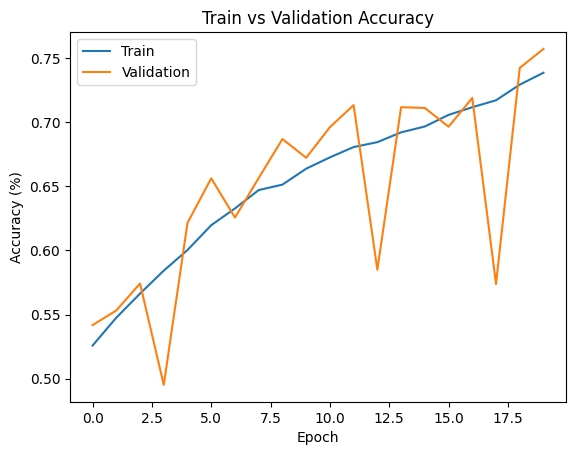

0.7566


In [ ]:
train(learning_rate, num_epochs, batch_size, training_data, validation_data, test_data)

**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

The gap in generalization is approximately 1.82%, which is quite small. This might be due to the limited number of epochs used.

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [ ]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([Embed(size = max_len, latent = embedding_size),
                                GRU(nin = embedding_size, nout = num_hidden_units_GRU),
                                objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
                                objax.functional.relu,
                                objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


In [ ]:
def train(learning_rate, num_epochs, batch_size, training_data, validation_data, test_data):

  X_train, Y_train = training_data
  X_valid, Y_valid = validation_data
  X_test, Y_test = test_data

  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(num_epochs):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], batch_size):
          batch = train_indices[it:it + batch_size]  # MY CODE
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], learning_rate)[0]) * len(batch)
          train_prediction = eval_op(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], batch_size):
          batch = val_indices[it:it + batch_size]  # MY CODE
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = eval_op(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

  print(accuracy((X_test, Y_test)))



Epoch 0001  Training Loss 155.50 Validation Loss 128.45 Training Accuracy 63.48 Validation Accuracy 75.06
Epoch 0002  Training Loss 129.23 Validation Loss 122.08 Training Accuracy 75.09 Validation Accuracy 76.68
Epoch 0003  Training Loss 126.29 Validation Loss 121.57 Training Accuracy 75.58 Validation Accuracy 76.60
Epoch 0004  Training Loss 127.82 Validation Loss 126.28 Training Accuracy 75.02 Validation Accuracy 75.94
Epoch 0005  Training Loss 130.74 Validation Loss 128.77 Training Accuracy 74.11 Validation Accuracy 74.60
Epoch 0006  Training Loss 130.96 Validation Loss 125.14 Training Accuracy 73.87 Validation Accuracy 74.82
Epoch 0007  Training Loss 129.24 Validation Loss 129.19 Training Accuracy 74.31 Validation Accuracy 74.68
Epoch 0008  Training Loss 126.62 Validation Loss 122.86 Training Accuracy 75.12 Validation Accuracy 76.20
Epoch 0009  Training Loss 124.32 Validation Loss 120.65 Training Accuracy 75.71 Validation Accuracy 77.00
Epoch 0010  Training Loss 123.16 Validation Lo

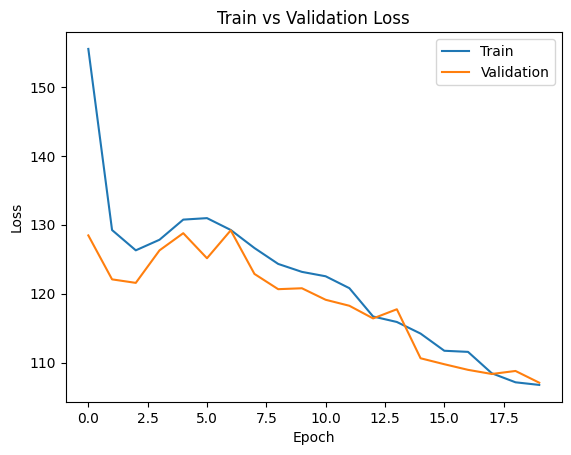

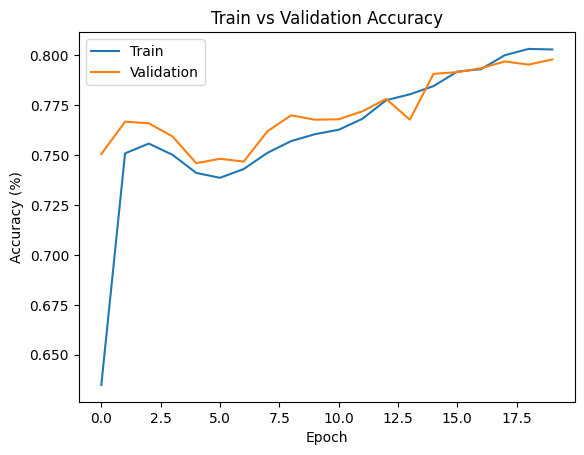

0.8


In [ ]:
train(learning_rate, num_epochs, batch_size, training_data, validation_data, test_data)

**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

Overall, Adam achieved higher accuracy than SGD, beginning with a higher initial accuracy. Additionally, Adam displayed fewer fluctuations in validation accuracy, maintaining a more consistent alignment between training and validation accuracies.

Regarding the generalization gap, it is at approximately 0.33% for Adam, which is smaller than that observed with SGD. However, given the limited number of epochs, the significance of this difference might be less pronounced.

**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

Adam optimizer is useful in handling sparse and noisy gradients. Unlike SGD, which employs a fixed or scheduled-decaying learning rate, Adam adjusts its learning rate for each parameter based on the first two moments of the gradients (mean and uncentered variance). This allows for faster convergence compared to SGD.

# Early Stopping

**Questions 16** [3 points]:
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [ ]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([Embed(size = max_len, latent = embedding_size),
                                GRU(nin = embedding_size, nout = num_hidden_units_GRU),
                                objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
                                objax.functional.relu,
                                objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
def train(learning_rate, num_epochs, batch_size, training_data, validation_data, test_data, max_patience_window):

  X_train, Y_train = training_data
  X_valid, Y_valid = validation_data
  X_test, Y_test = test_data

  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  patience = 0  # Initialize patience counter

  for epoch in range(num_epochs):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation
      train_indices = np.arange(len(X_train))
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], batch_size):
          batch = train_indices[it:it + batch_size]  # MY CODE
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], learning_rate)[0]) * len(batch)
          train_prediction = eval_op(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid))
      np.random.shuffle(val_indices)
      for it in range(0, X_valid.shape[0], batch_size):
          batch = val_indices[it:it + batch_size]  # MY CODE
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = eval_op(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      # Early Stopping Check
      current_val_loss = avg_val_loss_epoch[-1]
      if current_val_loss < best_val_loss:
          best_val_loss = current_val_loss
          patience = 0  # Reset patience because we see improvement
      else:
          patience += 1  # No improvement, so increase patience

      # Check if patience exceeded
      if patience >= max_patience_window:
          print("Early stopping triggered at epoch:", epoch + 1)
          break

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))

  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

  print(accuracy((X_test, Y_test)))


Epoch 0001  Training Loss 155.55 Validation Loss 133.42 Training Accuracy 63.80 Validation Accuracy 73.32
Epoch 0002  Training Loss 132.41 Validation Loss 127.40 Training Accuracy 74.35 Validation Accuracy 75.44
Epoch 0003  Training Loss 130.06 Validation Loss 127.73 Training Accuracy 74.44 Validation Accuracy 75.44
Epoch 0004  Training Loss 131.17 Validation Loss 134.00 Training Accuracy 74.25 Validation Accuracy 73.70
Epoch 0005  Training Loss 130.13 Validation Loss 125.15 Training Accuracy 74.46 Validation Accuracy 75.80
Epoch 0006  Training Loss 127.50 Validation Loss 124.14 Training Accuracy 74.89 Validation Accuracy 75.36
Epoch 0007  Training Loss 126.89 Validation Loss 124.14 Training Accuracy 75.12 Validation Accuracy 75.64
Epoch 0008  Training Loss 124.49 Validation Loss 120.69 Training Accuracy 75.83 Validation Accuracy 76.50
Epoch 0009  Training Loss 121.93 Validation Loss 119.21 Training Accuracy 76.53 Validation Accuracy 76.84
Epoch 0010  Training Loss 118.94 Validation Lo

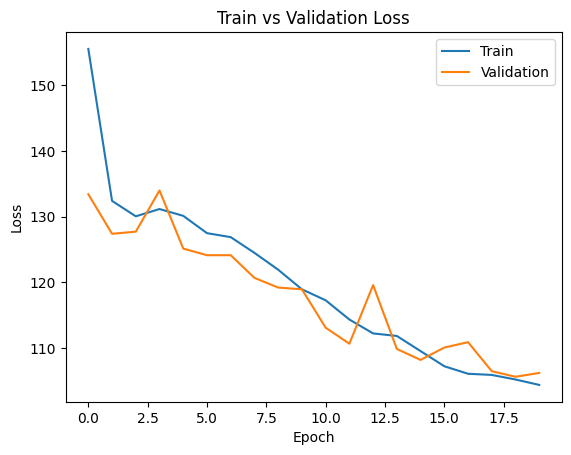

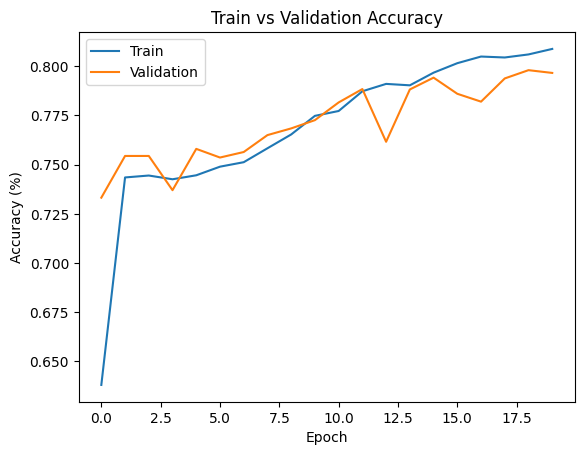

0.80420005


In [ ]:
train(learning_rate, num_epochs, batch_size, training_data, validation_data, test_data, max_patience_window)

**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

The best validation accuracy is 79.8%

The test accuracy is 80.42%


# Model cards

Our invited guest lecturer Deborah Raji presented her research about model cards as part of her lecture. In this last question, you are encouraged to read about model cards in [the publication by Mitchell et al.](https://arxiv.org/abs/1810.03993) co-authored by Deborah Raji.

**Question 18** [3 points] Write a model card for the model you developed in this assignment. Your card should at least contain 3 sections described in Figure 1 of the [paper by Mitchell et al.](https://arxiv.org/abs/1810.03993): Model Details, Intended Use, Metrics.

# **Model Card for Model with Early Stopping**

# **Model Details**

*   Developed by Lucia Sun at University of Toronto
*   Model Date: 2023-12-03
*   Model Type: RNN with GRU cells
*   Trained for sentiments detection on movie reviews

# **Intended Use**

*   Primary intended to use for ECE421 Fall 2023 Assignment 5 completion and classification of movie reviews

# **Metrics**

*   Validation Accuracy: 79.80%
*   Training Accuracy: 80.88%
*   Validation Loss: 105.63
*   Training Loss: 104.39
*   Test Accuracy: 80.42%
*   Generalization Gap: 0.46%

# **Training Data**

*   Trained on IMDB dataset that contains 50,000 movie reviews from the Internet Movie Database (IMDB) website
*   Data Split Ratio for Training:Validation:Testing is 8:1:1

